In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
A,D = 1.0, 0.1
tau_real = A/D
delta_t_list=np.linspace(0.01,20,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [5]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

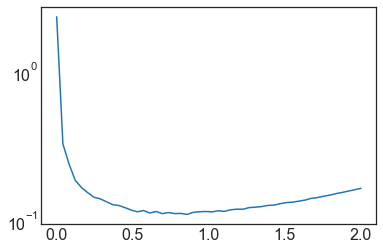

In [6]:
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3])

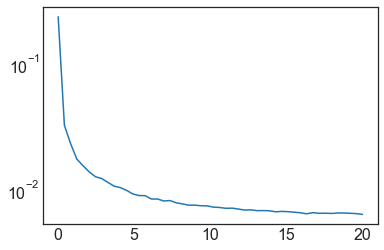

In [7]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [22]:
A,D = 1.0,0.1
tau_real = A/D
delta_t_list=np.linspace(0.01,20,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = -4
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

18.776122448979592


In [26]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000
sm.target_accept=0.9

In [27]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [11:55<00:00, 57.31draws/s] 
The acceptance probability does not match the target. It is 0.887453729403954, but should be close to 0.8. Try to increase the number of tuning steps.


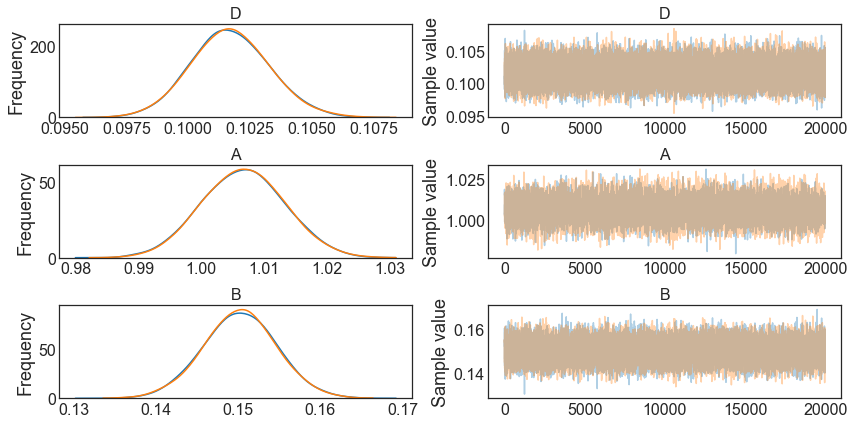

In [28]:
pm.traceplot(trace)
a_mean = trace['A'].mean()
d_mean = trace['D'].mean()
a_std = trace['A'].std()
d_std = trace['D'].std()

In [12]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:09<00:00, 317.66draws/s]


0.41795918367346935


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:19<00:00, 512.55draws/s]
The acceptance probability does not match the target. It is 0.8858417346447018, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8813160565250802, but should be close to 0.8. Try to increase the number of tuning steps.


0.8259183673469387


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:28<00:00, 463.75draws/s]
The acceptance probability does not match the target. It is 0.9081976779824039, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8920619119864174, but should be close to 0.8. Try to increase the number of tuning steps.


1.233877551020408


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:22<00:00, 496.66draws/s]
The acceptance probability does not match the target. It is 0.8995064895941399, but should be close to 0.8. Try to increase the number of tuning steps.


1.6418367346938774


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:14<00:00, 546.70draws/s]
The acceptance probability does not match the target. It is 0.8789589578177159, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8806630993608969, but should be close to 0.8. Try to increase the number of tuning steps.


2.0497959183673466


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:21<00:00, 502.36draws/s]
The acceptance probability does not match the target. It is 0.9000042809089649, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906016232670649, but should be close to 0.8. Try to increase the number of tuning steps.


2.457755102040816


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:28<00:00, 461.81draws/s]
The acceptance probability does not match the target. It is 0.8866942152165813, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916125402217591, but should be close to 0.8. Try to increase the number of tuning steps.


2.865714285714285


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:36<00:00, 424.99draws/s]
The acceptance probability does not match the target. It is 0.9046766601323889, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8880807781989302, but should be close to 0.8. Try to increase the number of tuning steps.


3.2736734693877545


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:55<00:00, 355.08draws/s]
The acceptance probability does not match the target. It is 0.9046336606693604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9587375763941379, but should be close to 0.8. Try to increase the number of tuning steps.


3.681632653061224


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:11<00:00, 312.58draws/s]
The acceptance probability does not match the target. It is 0.8946010411665666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.964616302154299, but should be close to 0.8. Try to increase the number of tuning steps.


4.0895918367346935


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:36<00:00, 262.16draws/s]
The acceptance probability does not match the target. It is 0.9515446377741404, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9587022849432246, but should be close to 0.8. Try to increase the number of tuning steps.


4.497551020408163


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:17<00:00, 298.88draws/s]
The acceptance probability does not match the target. It is 0.9240810863300741, but should be close to 0.8. Try to increase the number of tuning steps.


4.905510204081632


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:51<00:00, 369.13draws/s]
The acceptance probability does not match the target. It is 0.8882860434152708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9007706835885179, but should be close to 0.8. Try to increase the number of tuning steps.


5.313469387755101


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:08<00:00, 319.51draws/s]
The acceptance probability does not match the target. It is 0.8899829178451323, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9182064783544667, but should be close to 0.8. Try to increase the number of tuning steps.


5.721428571428571


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:35<00:00, 264.41draws/s]
The acceptance probability does not match the target. It is 0.8869100990011227, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9694187475953701, but should be close to 0.8. Try to increase the number of tuning steps.


6.12938775510204


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:41<00:00, 403.88draws/s]
The acceptance probability does not match the target. It is 0.8917680777314893, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8887412736238296, but should be close to 0.8. Try to increase the number of tuning steps.


6.537346938775509


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:49<00:00, 373.58draws/s]
The acceptance probability does not match the target. It is 0.8943326295284366, but should be close to 0.8. Try to increase the number of tuning steps.


6.9453061224489785


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:20<00:00, 292.22draws/s]
The acceptance probability does not match the target. It is 0.9532259862191435, but should be close to 0.8. Try to increase the number of tuning steps.


7.353265306122448


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [03:15<00:00, 210.04draws/s]
The acceptance probability does not match the target. It is 0.9026578147285628, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9578628151305079, but should be close to 0.8. Try to increase the number of tuning steps.


7.761224489795917


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [11:21<00:00, 60.14draws/s]
The acceptance probability does not match the target. It is 0.8865486004745694, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8875825750017294, but should be close to 0.8. Try to increase the number of tuning steps.


8.169183673469387


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [09:26<00:00, 72.34draws/s] 
The acceptance probability does not match the target. It is 0.8914680762124846, but should be close to 0.8. Try to increase the number of tuning steps.


8.577142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:10<00:00, 313.74draws/s]
The acceptance probability does not match the target. It is 0.9354607879373311, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9486616558069971, but should be close to 0.8. Try to increase the number of tuning steps.


8.985102040816326


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:11<00:00, 311.14draws/s]
The acceptance probability does not match the target. It is 0.9629784282938039, but should be close to 0.8. Try to increase the number of tuning steps.


9.393061224489795


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:12<00:00, 221.72draws/s]
The acceptance probability does not match the target. It is 0.9645257413354831, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790596460089669, but should be close to 0.8. Try to increase the number of tuning steps.


9.801020408163264


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [03:52<00:00, 176.14draws/s]
The acceptance probability does not match the target. It is 0.881611572042716, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9957768853026432, but should be close to 0.8. Try to increase the number of tuning steps.


10.208979591836734


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:34<00:00, 432.87draws/s]
The acceptance probability does not match the target. It is 0.8858507821902999, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895505047065609, but should be close to 0.8. Try to increase the number of tuning steps.


10.616938775510203


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:35<00:00, 431.41draws/s]
The acceptance probability does not match the target. It is 0.893027019260304, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867810938882695, but should be close to 0.8. Try to increase the number of tuning steps.


11.024897959183672


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:34<00:00, 435.84draws/s]
The acceptance probability does not match the target. It is 0.8873902330556442, but should be close to 0.8. Try to increase the number of tuning steps.


11.432857142857141


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:56<00:00, 350.73draws/s]
The acceptance probability does not match the target. It is 0.9479988028180811, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8793728289955784, but should be close to 0.8. Try to increase the number of tuning steps.


11.84081632653061


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:02<00:00, 333.40draws/s]
The acceptance probability does not match the target. It is 0.955696118423008, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.885149814903606, but should be close to 0.8. Try to increase the number of tuning steps.


12.24877551020408


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:35<00:00, 430.32draws/s]
The acceptance probability does not match the target. It is 0.8995447175626938, but should be close to 0.8. Try to increase the number of tuning steps.


12.65673469387755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [03:28<00:00, 196.56draws/s]
The acceptance probability does not match the target. It is 0.9948878704144724, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


13.064693877551019


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:05<00:00, 327.05draws/s]
The acceptance probability does not match the target. It is 0.9502323304336809, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9274670553452316, but should be close to 0.8. Try to increase the number of tuning steps.


13.472653061224488


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:45<00:00, 388.18draws/s]
There were 17775 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.13558070636406705, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9270403222119753, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


13.880612244897957


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:14<00:00, 305.23draws/s]
The acceptance probability does not match the target. It is 0.8795405968111133, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9617469614428233, but should be close to 0.8. Try to increase the number of tuning steps.


14.288571428571426


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:17<00:00, 298.87draws/s]
The acceptance probability does not match the target. It is 0.9573763934289821, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9552764433835707, but should be close to 0.8. Try to increase the number of tuning steps.


14.696530612244896


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:07<00:00, 320.74draws/s]
The acceptance probability does not match the target. It is 0.8804615717659631, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9613451727674536, but should be close to 0.8. Try to increase the number of tuning steps.


15.104489795918365


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:19<00:00, 294.59draws/s]
The acceptance probability does not match the target. It is 0.9536717704619847, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9573181124953369, but should be close to 0.8. Try to increase the number of tuning steps.


15.512448979591834


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [04:48<00:00, 142.25draws/s]
The acceptance probability does not match the target. It is 0.997571636800248, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933208260428552, but should be close to 0.8. Try to increase the number of tuning steps.


15.920408163265304


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:11<00:00, 311.74draws/s]
The acceptance probability does not match the target. It is 0.9637547565196134, but should be close to 0.8. Try to increase the number of tuning steps.


16.328367346938776


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [04:46<00:00, 143.11draws/s]
The acceptance probability does not match the target. It is 0.9975994826107394, but should be close to 0.8. Try to increase the number of tuning steps.


16.736326530612246


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [03:19<00:00, 205.30draws/s]
The acceptance probability does not match the target. It is 0.9935732940543323, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8833805302751243, but should be close to 0.8. Try to increase the number of tuning steps.


17.144285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:09<00:00, 317.30draws/s]
The acceptance probability does not match the target. It is 0.8922924997924284, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9605544189922623, but should be close to 0.8. Try to increase the number of tuning steps.


17.552244897959184


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:33<00:00, 437.17draws/s]
The acceptance probability does not match the target. It is 0.8887880886909998, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8980401972582124, but should be close to 0.8. Try to increase the number of tuning steps.


17.960204081632654


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:33<00:00, 437.39draws/s]
The acceptance probability does not match the target. It is 0.9009139232555027, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8885302338454024, but should be close to 0.8. Try to increase the number of tuning steps.


18.368163265306123


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:28<00:00, 464.29draws/s]
The acceptance probability does not match the target. It is 0.8837527468660996, but should be close to 0.8. Try to increase the number of tuning steps.


18.776122448979592


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:03<00:00, 258.11draws/s]
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.014333132090363245, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8973437943108439, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


19.18408163265306


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:25<00:00, 282.39draws/s]
The acceptance probability does not match the target. It is 0.9568474101033339, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8951756528403132, but should be close to 0.8. Try to increase the number of tuning steps.


19.59204081632653


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:09<00:00, 316.04draws/s]
The acceptance probability does not match the target. It is 0.9391386072284739, but should be close to 0.8. Try to increase the number of tuning steps.


20.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:54<00:00, 357.56draws/s]
The acceptance probability does not match the target. It is 0.8811904223265888, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9036014975694856, but should be close to 0.8. Try to increase the number of tuning steps.


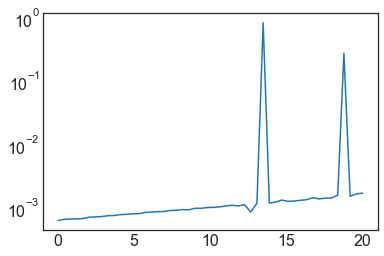

In [13]:
plt.semilogy(delta_t_list,result_array.T[3])

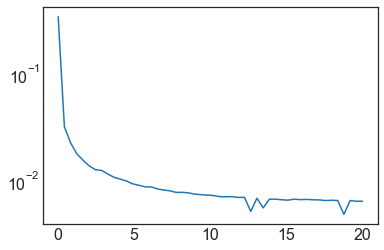

In [14]:
plt.semilogy(delta_t_list,result_array.T[1])

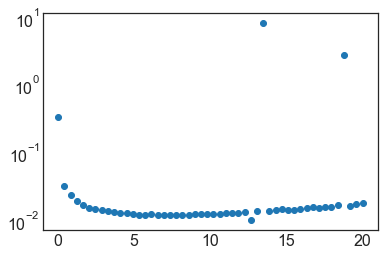

In [19]:
dtau = np.sqrt(result_array.T[1]**2/D**2+A**2/D**4*result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau/tau_real,"o")

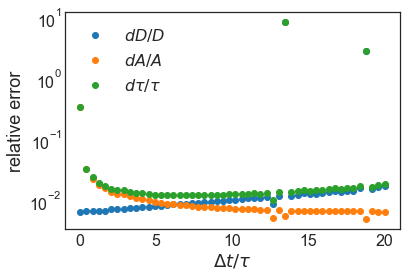

In [20]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

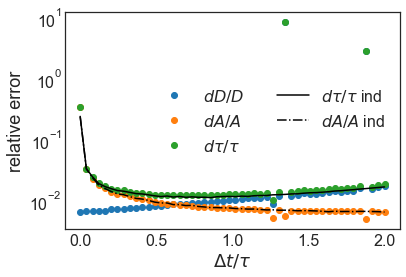

In [21]:
plt.semilogy(delta_t_list/tau_real,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list/tau_real,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list/tau_real,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_2.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")